In this notebook, we'll use the built in simulation functions to create some simulated brain objects, create a model from those objects and then predict a new brain object with the model.

## Load in libraries

In [1]:
import superEEG as se
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist

np.random.seed(2)

## Simulate subject data

First, we'll simulate 10 brain objects with 50 randomly placed electrodes each.  We'll use this data to construct a model.  Then, we'll simulate one more subject with 25 electrodes and predict that subject's data with our model.

In [2]:
# brain objects to build the model
model_bos = [se.simulate_bo(n_samples=10000, sample_rate=1000, n_elecs=50) for i in range(10)]

# brain object to evaluate the model
bo = se.simulate_bo(n_samples=10000, sample_rate=1000, n_elecs=25)

## Construct our model

To construct the model, we'll pass the list of brain objects to the `se.Model` function.  We can plot the model using the `model.plot` method (this wraps `seaborn.heatmap` so you can pass any arg that heatmap accepts to customize the plot).

/Users/andyheusser/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/andyheusser/Documents/github/superEEG/superEEG/brain.py:111: UserWarning: No sample rate given.  Setting sample rate to 1000
  warnings.warn('No sample rate given.  Setting sample rate to 1000')
/Users/andyheusser/Documents/github/superEEG/superEEG/_helpers/stats.py:143: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (np.log(1 + r) - np.log(1 - r))
/Users/andyheusser/Documents/github/superEEG/superEEG/model.py:326: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(z2r(np.divide(self.numerator, self.denominator)), **kwargs)


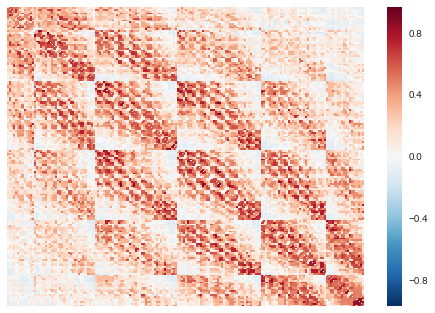

In [3]:
# construct the model
model = se.Model(model_bos)

# plot the model
model.plot(yticklabels=False, xticklabels=False)

## Checking the model

The simulated data is created by randomly selecting coordinates in MNI space, and then sampling the data from a multivariate normal where the covariance matrix is defined by the distances between the simulated electrode locations.  The intuition here is that nearby electrode locations will be more correlated than electrodes that are further apart. Contrasting the model to the actual distances of the electrode locations helps us to verify that our model was created correctly.  Essentially, this simulated model should be a noisy version of the euclidean distances between electrode locations, which appears to be true.

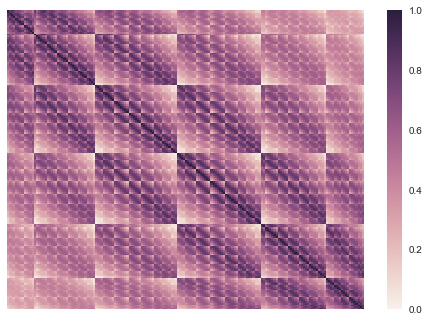

In [4]:
# compute the euclidean distances between the electrode locations
loc_dist = 1 - cdist(model.locs, model.locs, metric='euclidean')

# normalize the matrix
loc_dist -= np.min(loc_dist)
loc_dist /= np.max(loc_dist)

# and plot
sns.heatmap(loc_dist, xticklabels=False, yticklabels=False)
sns.plt.show()

## Predicting new data

Now that we're confident the model is correct, we can reconstruct a new subjects data using the model.  To do this, we simply pass the `bo` to the `model.predict` method and it returns a reconstruction.  One way to check that our reconstruction works is to compute an elecs by elecs correlation matrix.  This should look similar to the matrices displayed above. As you can see below, it does indeed.

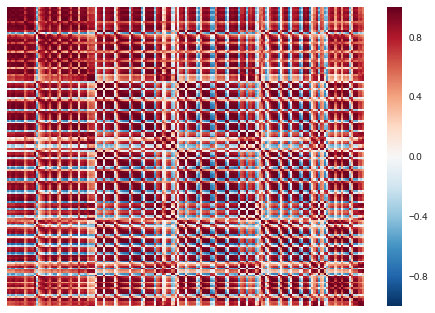

In [64]:
# reconstruct the bo with the model
recon = model.predict(bo)

# plot the elecs by elecs correlation matrix
sns.heatmap(recon.data.corr(), yticklabels=False, xticklabels=False)
sns.plt.show()

## Correlating original data with the reconstruction

As a final test of the reconstruction, we can test whether the timeseries for the original electrodes and nearest reconstructed electrode are similar.  To do this, we'll find the nearest reconstructed electrode to each original electrode and plot the correlation.  These should be correlated, but not perfectly since the electrode locations were sampled randomly.

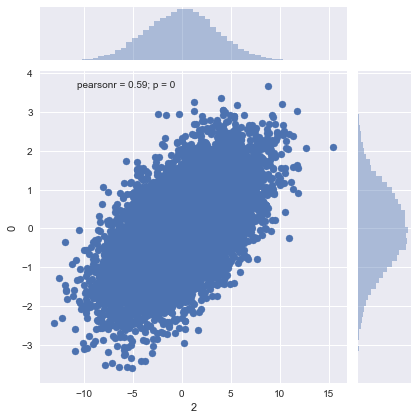

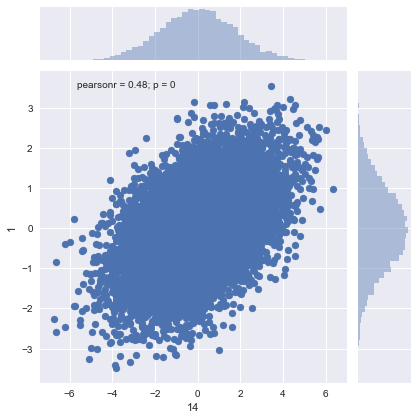

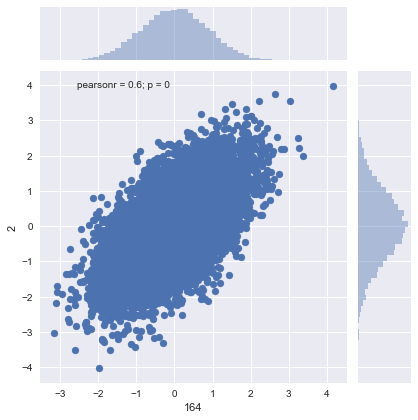

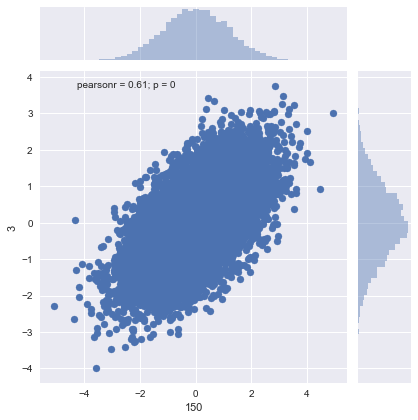

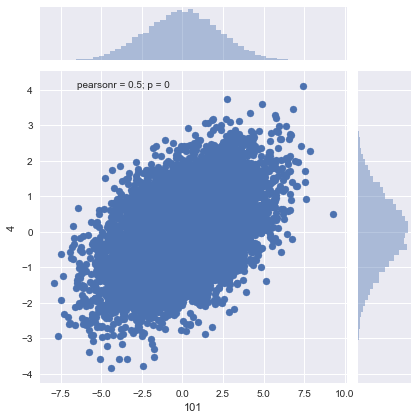

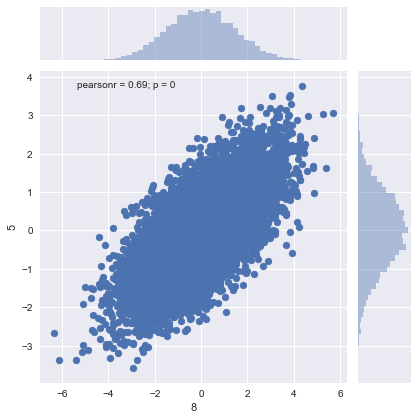

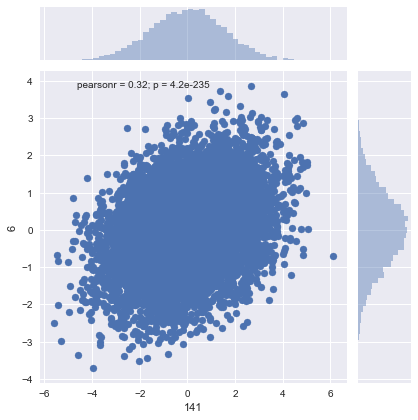

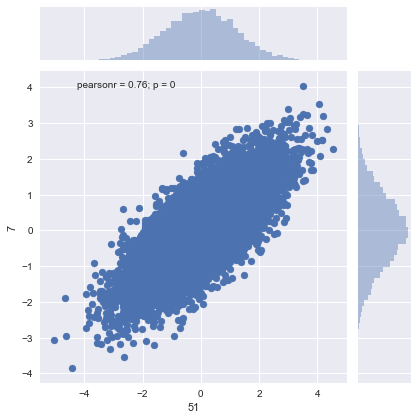

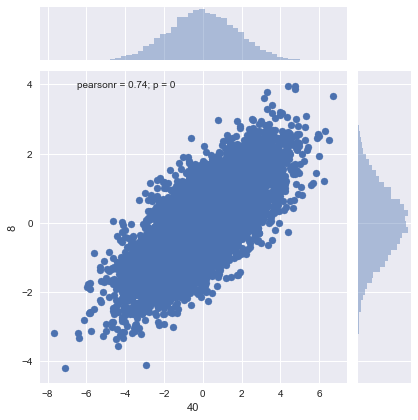

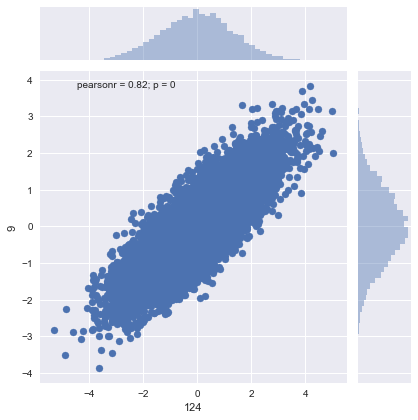

In [65]:
closest = recon.data.iloc[:, np.argmin(cdist(recon.locs, bo.locs, 'euclidean'), axis=0)]
for elec in range(10):
    sns.jointplot(closest.iloc[:,elec], bo.data.iloc[:,elec])
    sns.plt.show()